<a href="https://colab.research.google.com/github/fralfaro/MAT306/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT306 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [1]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [2]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [3]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT306/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [4]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



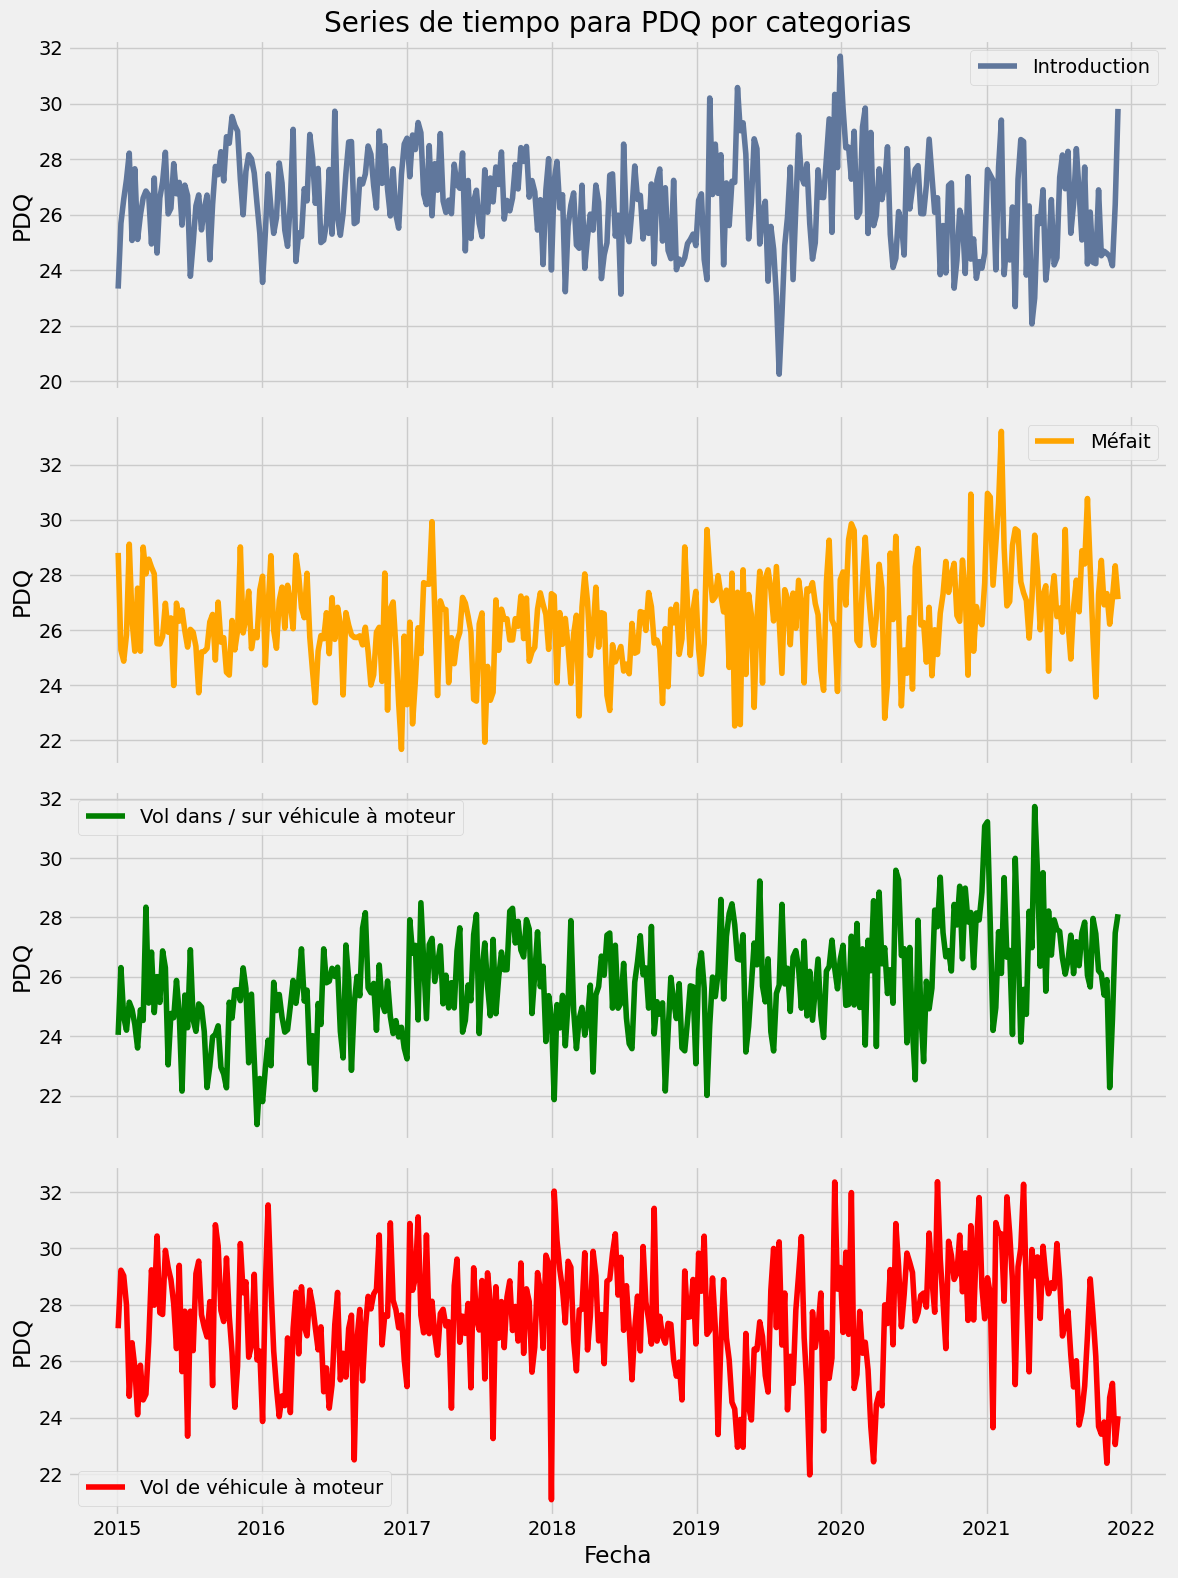

In [5]:
# Plotting the time series
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

axes[0].plot(y_s1, label=validate_categorie[0])
axes[0].set_ylabel('PDQ')
axes[0].set_title('Series de tiempo para PDQ por categorias')
axes[0].legend()

axes[1].plot(y_s2, label=validate_categorie[1], color='orange')
axes[1].set_ylabel('PDQ')
axes[1].legend()

axes[2].plot(y_s3, label=validate_categorie[2], color='green')
axes[2].set_ylabel('PDQ')
axes[2].legend()

axes[3].plot(y_s4, label=validate_categorie[3], color='red')
axes[3].set_ylabel('PDQ')
axes[3].set_xlabel('Fecha')
axes[3].legend()

plt.tight_layout()
plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [6]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

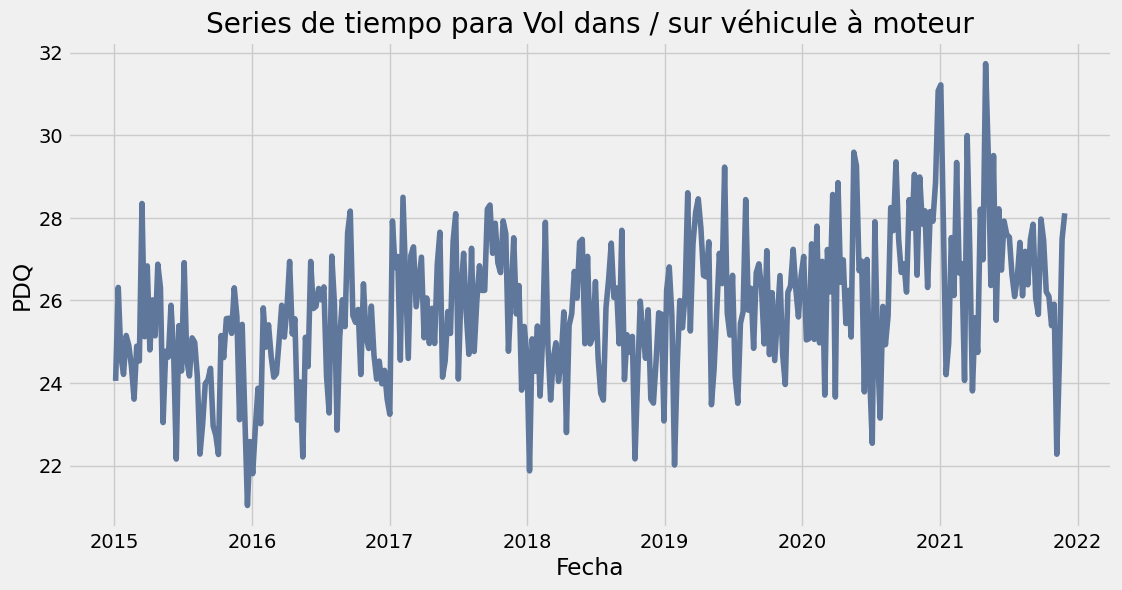

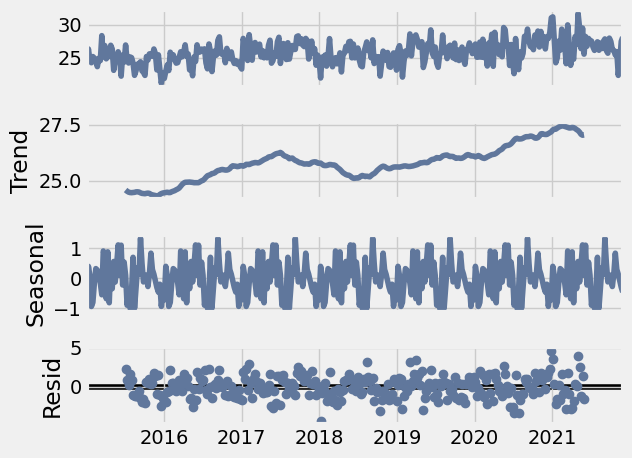

In [7]:

plt.figure(figsize=(12, 6))
plt.plot(y_s3)
plt.title(f'Series de tiempo para {validate_categorie[2]}')
plt.ylabel('PDQ')
plt.xlabel('Fecha')
plt.show()

decomposition = sm.tsa.seasonal_decompose(y_s3, model='additive')
fig = decomposition.plot()
plt.show()

Se escogio la tercera categoria "Robo dentro/fuera del auto". Se realiza una descomposicon de esta serie de tiempo para determinar si hay alguna tendencia. Como se indica en trend, hay una tendencia hacia el alza de este tipo de robos, pese que no estan claro del primer grafico. En el grafico de residuos no vemos un patron claro de tendencia, lo que puede indicar que solo se ve ruido implicando que la tendencia ha sido captada de forma general.

In [8]:
results = []
for param in params:
    try:
        model = SarimaModels(param)
        df_metrics = model.metrics(y_s3, target_date)
        results.append(df_metrics)
    except:
        continue


sarima_results_df = pd.concat(results, ignore_index=True)

sarima_results_df_sorted = sarima_results_df.sort_values(by='rmse')
display(sarima_results_df_sorted)

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
37,1.3657,3.1739,1.7815,0.0511,0.0509,0.0508,0.0492,0.0508,"SARIMA_(1,0,0)X(1,0,1,12)"
13,1.3788,3.2506,1.8029,0.0515,0.0513,0.0513,0.0497,0.0513,"SARIMA_(0,0,1)X(1,0,1,12)"
45,1.3777,3.2973,1.8158,0.0519,0.0517,0.0512,0.0500,0.0512,"SARIMA_(1,0,1)X(1,0,1,12)"
11,1.3671,3.3476,1.8296,0.0500,0.0499,0.0508,0.0483,0.0508,"SARIMA_(0,0,1)X(0,1,1,12)"
15,1.3671,3.3476,1.8297,0.0501,0.0499,0.0508,0.0483,0.0508,"SARIMA_(0,0,1)X(1,1,1,12)"
...,...,...,...,...,...,...,...,...,...
18,13.5654,221.9233,14.8971,0.5134,0.4559,0.5044,0.4946,0.3932,"SARIMA_(0,1,0)X(0,1,0,12)"
1,23.2099,586.6421,24.2207,0.8634,0.6930,0.8631,0.8323,1.6564,"SARIMA_(0,0,0)X(0,0,1,12)"
9,23.4758,587.2360,24.2330,0.8737,0.7040,0.8730,0.8422,1.6618,"SARIMA_(0,0,1)X(0,0,1,12)"
8,26.6276,713.2692,26.7071,0.9915,0.7802,0.9902,0.9558,1.9759,"SARIMA_(0,0,1)X(0,0,0,12)"


Probamos con los diferentes parametros en params. Luego se escogio el que tiene menor rmse, pues, este determina la mejor aproximación a los datos disminuyendo el error cuadratico medio.

Los mejores parametros fueron ((1, 0, 0), (1, 0, 1, 12))

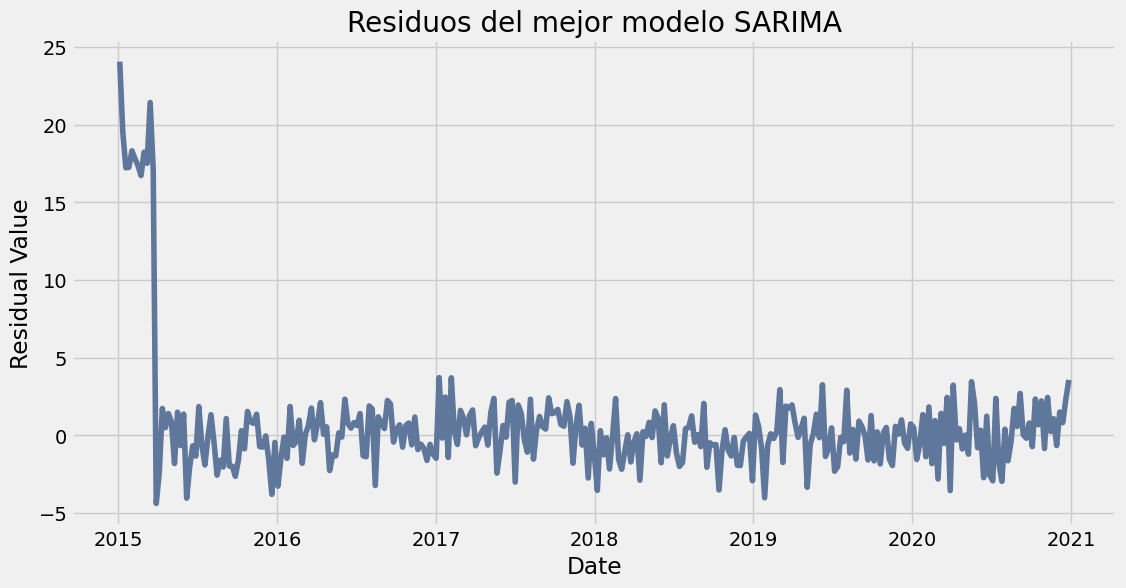

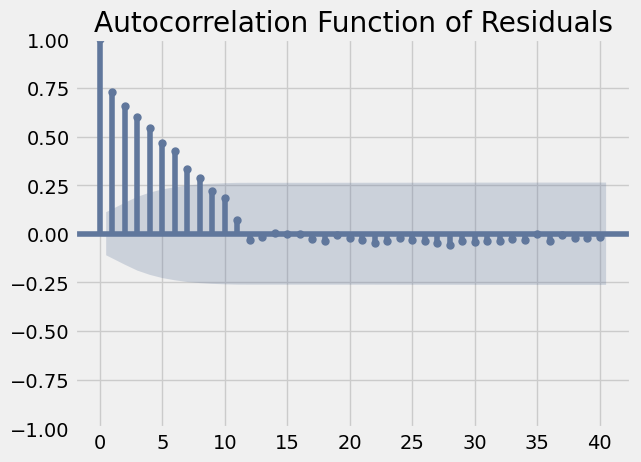

Ljung-Box Test Results:


,lb_stat,lb_pvalue
10,730.277349,1.980064e-150
20,733.285429,1.987376e-142


In [9]:

best_model_params = ((1, 0, 0), (1, 0, 1, 12))

best_sarima_model = SarimaModels(best_model_params)


y_train, y_test = best_sarima_model.test_train_model(y_s3, target_date)


model_fit = best_sarima_model.fit_model(y_s3, target_date)

residuals = model_fit.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuos del mejor modelo SARIMA')
plt.ylabel('Residual Value')
plt.xlabel('Date')
plt.show()


sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title('Autocorrelation Function of Residuals')
plt.show()


ljung_box_test = sm.stats.acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
print("Ljung-Box Test Results:")
display(ljung_box_test)

Ahora se entrena el mejor modelo establecido anteriormente. Se grafican los residuos, AFC y se hace un test de hipotesis "Ljung-Box", este ultimo sugerido por la IA.

En el grafico de residuos se notan clusters y oscilaciones cerca del 0, ademas, de una alza que va hacia la baja. Esto indica que el ruido blanco no es puramente azaroso.

Por otro lado el grafico AFC, se espera que el peak inicial baje justamente en la zona azul. Lo que no sucede. Esto tambien es un indicativo de que el ruido blanco aun tiene correlaciones, es decir, no es tan blanco.

El test de Ljung-Box y su bajo valor p indica que hay evidiencia estadistica para rechazar que el ruido blanco no es azoroso, es decir, que aun hay dependencias entre la data que el modelo no ha capturado.

En resumen, si bien el modelo es el mejor dentro de los parametros, este no capta del todo la tendencia y aun tiene data por captar.




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [10]:
from prophet import Prophet

prophet_df = y_s3.reset_index().rename(columns={'date': 'ds', 'pdq': 'y'})


prophet_train_df = prophet_df[prophet_df['ds'] < target_date]
prophet_test_df = prophet_df[prophet_df['ds'] >= target_date]

display(prophet_train_df.head())
display(prophet_test_df.head())

,ds,y
0,2015-01-04,24.049383
1,2015-01-11,26.313333
2,2015-01-18,24.652174
3,2015-01-25,24.206349
4,2015-02-01,25.149485


,ds,y
313,2021-01-03,31.220000
314,2021-01-10,27.801527
315,2021-01-17,24.200000
316,2021-01-24,24.966667
317,2021-01-31,27.520833


In [11]:
model_prophet = Prophet()
model_prophet.fit(prophet_train_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:

future = model_prophet.make_future_dataframe(periods=len(prophet_test_df), freq='W')

forecast = model_prophet.predict(future)

display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-04,23.947472,22.060647,25.698282
1,2015-01-11,23.986166,22.214292,25.913307
2,2015-01-18,24.004561,22.179132,25.668654
3,2015-01-25,24.136872,22.333313,25.952346
4,2015-02-01,24.371144,22.522350,26.320165


In [13]:

prophet_results = forecast.set_index('ds')[['yhat']].join(prophet_test_df.set_index('ds')[['y']]).dropna()

prophet_metrics = summary_metrics(prophet_results)
prophet_metrics['model'] = 'Prophet'

display(prophet_metrics)

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.5929,4.4892,2.1188,0.0609,0.0605,0.0592,0.0586,0.0589,Prophet


In [14]:

if 'sarima_results_df_sorted' in locals():
    best_sarima_metrics = sarima_results_df_sorted.iloc[0].to_frame().T

    if 'model' not in best_sarima_metrics.columns:
        best_sarima_metrics['model'] = sarima_results_df_sorted.iloc[0]['model']

    comparison_metrics = pd.concat([best_sarima_metrics, prophet_metrics], ignore_index=True)

    display(comparison_metrics)
else:
    print("SARIMA results DataFrame 'sarima_results_df_sorted' not found. Please ensure the SARIMA modeling step was executed.")

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.3657,3.1739,1.7815,0.0511,0.0509,0.0508,0.0492,0.0508,"SARIMA_(1,0,0)X(1,0,1,12)"
1,1.5929,4.4892,2.1188,0.0609,0.0605,0.0592,0.0586,0.0589,Prophet


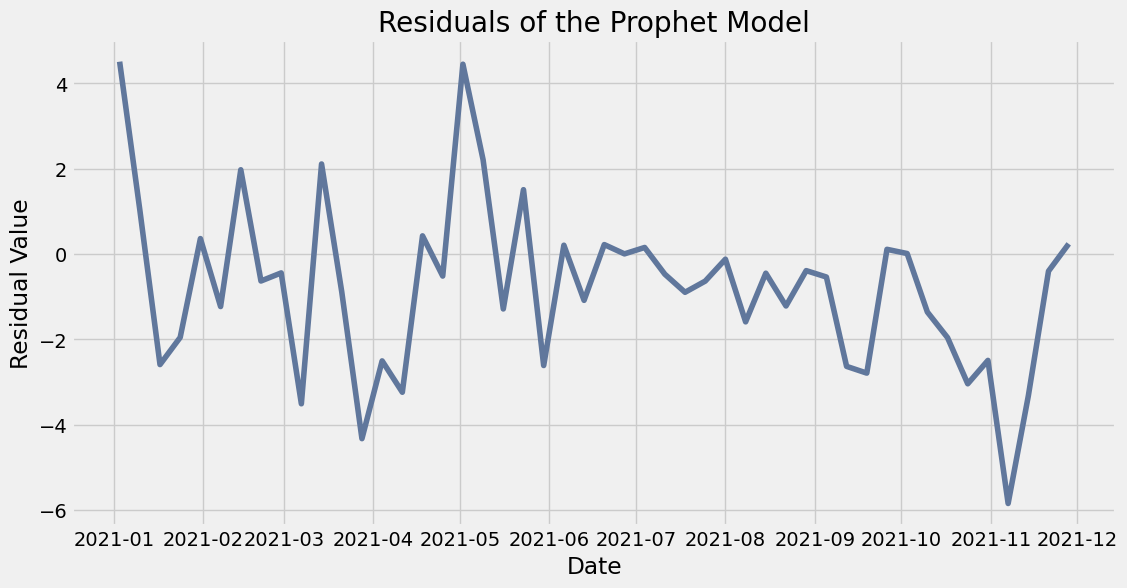

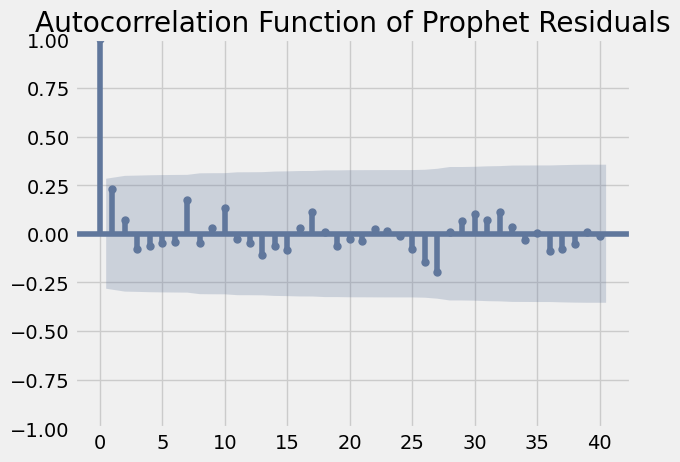

Ljung-Box Test Results for Prophet Residuals:


,lb_stat,lb_pvalue
10,6.869791,0.737678
20,10.107314,0.966184


In [15]:
prophet_residuals = prophet_results['y'] - prophet_results['yhat']


plt.figure(figsize=(12, 6))
plt.plot(prophet_residuals)
plt.title('Residuals of the Prophet Model')
plt.ylabel('Residual Value')
plt.xlabel('Date')
plt.show()

sm.graphics.tsa.plot_acf(prophet_residuals, lags=40)
plt.title('Autocorrelation Function of Prophet Residuals')
plt.show()

ljung_box_test_prophet = sm.stats.acorr_ljungbox(prophet_residuals, lags=[10, 20], return_df=True)
print("Ljung-Box Test Results for Prophet Residuals:")
display(ljung_box_test_prophet)

Primero se comparan las metricas entre SARIMA y Prophet, se evidencia que en cuanto a esto, SARIMA se desempeña mejor que Prophet. Sin embargo, luego se hace los mismo graficos para sonido blanco, donde se obtiene que si podemos que el ruido blanco es ruido.

Note que en el grafico de residuo si se un patron azoroso y en el grafico de ACF, a diferencia de SARIMA, el peak baja en el area azul que es lo que se espera para indicar que es un ruido blanco y por ultimo, el test de hipotesis indica que hay evidiencia suficiente para no rechazar la hipotesis nula, es decir, no existe dependencia entre el ruido blanco y los datos

